In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel
from matplotlib import pyplot as plt

# Load and inspect data

In [2]:
df = pd.read_csv("data/d1.csv")
print(len(df))
df.head(5)

100


,id,pot,f,y
0,1,A,C,6
1,2,A,C,3
2,3,A,C,19
3,4,A,C,5
4,5,A,C,0


In [3]:
df.nunique()

id     100
pot     10
f        2
y       20
dtype: int64

In [4]:
df["y"].min(), df["y"].max()

(0, 37)

In [5]:
pd.crosstab(df["pot"], df["f"])

f,C,T
pot,,
A,10,0
B,10,0
C,10,0
D,10,0
E,10,0
F,0,10
G,0,10
H,0,10
I,0,10


In [6]:
df.groupby("pot")["id"].count()

pot
A    10
B    10
C    10
D    10
E    10
F    10
G    10
H    10
I    10
J    10
Name: id, dtype: int64

<AxesSubplot:xlabel='f', ylabel='y'>

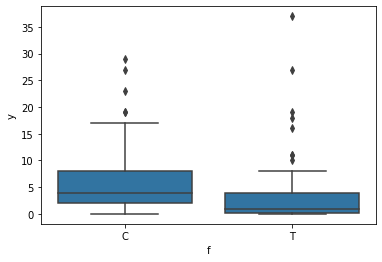

In [7]:
sns.boxplot(data=df, x="f", y="y", color="C0")

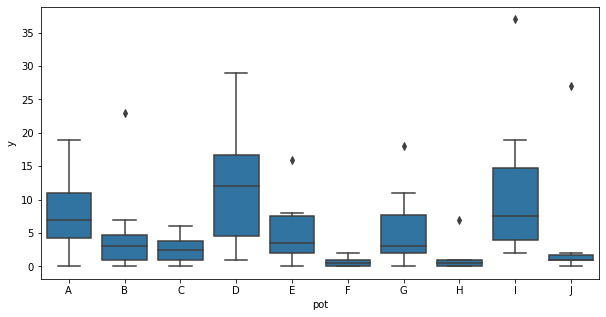

In [8]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
sns.boxplot(ax=ax, data=df, x="pot", y="y", color="C0")
fig.show()

# Run Stan

In [9]:
model = CmdStanModel(stan_file="model/exercise8-7.stan")
print(model)

INFO:cmdstanpy:compiling stan program, exe file: /workdir/chapter08/model/exercise8-7
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /workdir/chapter08/model/exercise8-7


CmdStanModel: name=exercise8-7
	 stan_file=/workdir/chapter08/model/exercise8-7.stan
	 exe_file=/workdir/chapter08/model/exercise8-7
	 compiler_optons=stanc_options=None, cpp_options=None


In [10]:
data = {
    "I": len(df),
    "P": int(df.nunique()["pot"]),
    "pot": df["pot"].replace({char: idx+1 for idx, char in enumerate(df["pot"].unique())}).values,
    "f": df["f"].replace({"C": 0, "T": 1}).values,
    "y": df["y"].values
}

In [11]:
fit = model.sample(data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2


# Check the result

In [12]:
print(fit.diagnose())

INFO:cmdstanpy:Processing csv files: /tmp/tmpiumr629_/exercise8-7-202010271234-1-q_m0eadk.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-2-h2y3bwzt.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-3-bbgybgpv.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-4-mqwfsr7o.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


Processing csv files: /tmp/tmpiumr629_/exercise8-7-202010271234-1-q_m0eadk.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-2-h2y3bwzt.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-3-bbgybgpv.csv, /tmp/tmpiumr629_/exercise8-7-202010271234-4-mqwfsr7o.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


In [13]:
y_pred_percentiles = np.percentile(fit.stan_variable("y_pred"), [10.0, 50.0, 90.0], axis=0)

(0.0, 20.0)

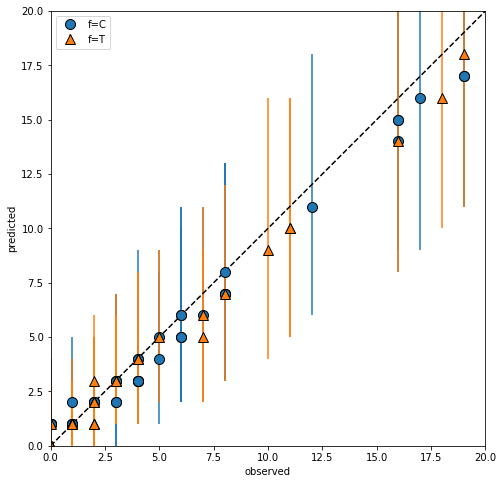

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)

idx0 = np.where(df["f"].values == "C")[0]
idx1 = np.where(df["f"].values == "T")[0]

ax.errorbar(
    x=df["y"].values[idx0], 
    y=y_pred_percentiles[1][idx0], 
    yerr=np.abs(y_pred_percentiles[[0, 2]][:, idx0] - y_pred_percentiles[1][idx0]),
    fmt='o',
    markersize=10,
    markeredgecolor='k',
    label="f=C"
)

ax.errorbar(
    x=df["y"].values[idx1], 
    y=y_pred_percentiles[1][idx1], 
    yerr=np.abs(y_pred_percentiles[[0, 2]][:, idx1] - y_pred_percentiles[1][idx1]),
    fmt='^',
    markersize=10,
    markeredgecolor='k',
    label="f=T"
)

ax.legend()
ax.plot([0.0, 40.0], [0.0, 40.0], 'k--')
ax.set_aspect("equal")
ax.set_xlabel("observed")
ax.set_ylabel("predicted")
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)

予測値は、観測値を下回る方向に偏っている?

# Interpret the result

In [15]:
fit.summary().loc[["b[1]", "b[2]", "s_P", "s_I"]]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
b[1],1.30,0.028,0.59,0.53,1.40,2.20,459.00,82.00,1.00
b[2],-0.83,0.022,0.71,-2.00,-0.84,0.35,1010.00,180.00,1.00
s_P,1.06,0.020,0.45,0.58,0.97,1.81,420.27,74.73,1.01
s_I,1.02,0.000,0.12,0.84,1.01,1.22,1440.57,256.15,1.00


個体差、鉢差の大きさは同程度。
また、処理の違いはあまり大きくなく、個体差、鉢差の方が大きい。

In [16]:
np.exp(2)

7.38905609893065

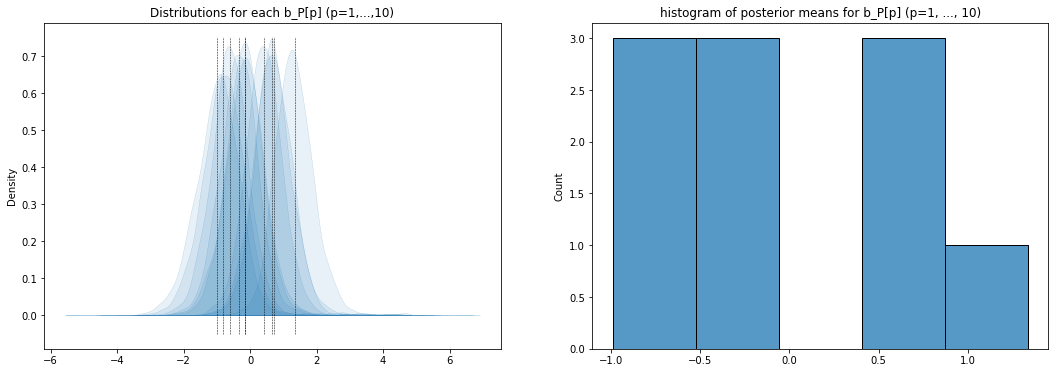

In [17]:
# Pot

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
b_P_means = fit.stan_variable("b_P").mean(axis=0)

for i in range(df.nunique()["pot"]):
    axes[0].plot([b_P_means[i], b_P_means[i]], [-0.05, 0.75], "k--", linewidth=0.5)
    sns.kdeplot(ax=axes[0], x=fit.stan_variable("b_P")[:, i], linewidth=0.1, fill=True, color="C0", alpha=0.1)
axes[0].set_title("Distributions for each b_P[p] (p=1,...,10)")

sns.histplot(ax=axes[1], x=b_P_means)
axes[1].set_title("histogram of posterior means for b_P[p] (p=1, ..., 10)")
fig.show()

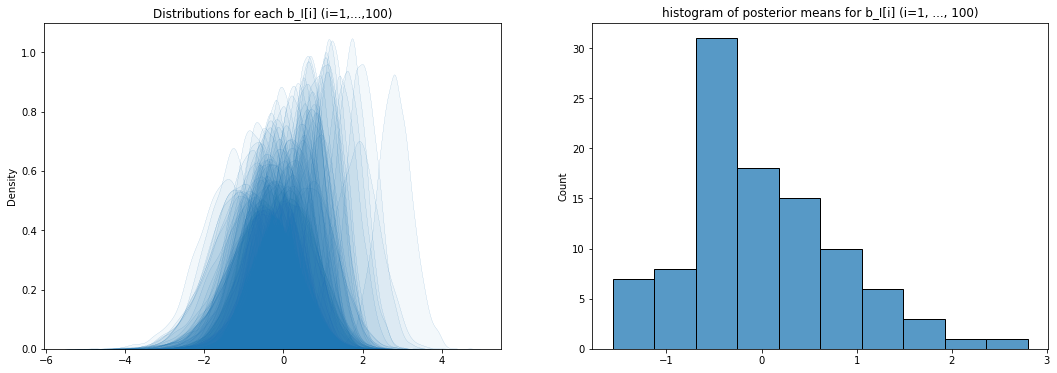

In [18]:
# individual

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
b_I_means = fit.stan_variable("b_I").mean(axis=0)

for i in range(len(df)):
    #axes[0].plot([b_I_means[i], b_I_means[i]], [-0.05, 1.0], "k--", linewidth=0.1)
    sns.kdeplot(ax=axes[0], x=fit.stan_variable("b_I")[:, i], linewidth=0.1, fill=True, color="C0", alpha=0.05)
axes[0].set_title("Distributions for each b_I[i] (i=1,...,100)")

sns.histplot(ax=axes[1], x=b_I_means)
axes[1].set_title("histogram of posterior means for b_I[i] (i=1, ..., 100)")
fig.show()